# Permutation tests when a sample = a time at t?

This notebook is with a version $t_{i+1} = t_i + N(\mu, \sigma)$

- first date: 12.August.2021
- updated date: 23.August.2021

In [1]:
import sys
sys.path.append("../")
sys.path.append(".")

In [2]:
from model_criticism_mmd import ModelTrainerTorchBackend, MMD, TwoSampleDataSet
from model_criticism_mmd import kernels_torch
from model_criticism_mmd import PermutationTest, SelectionKernels

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [3]:
import torch
device_obj = torch.device('cpu')

# Data preparations

In [4]:
import numpy as np
import tqdm

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
N_DATA_SIZE = 500
N_TIME_LENGHTH = 100
NOISE_MU_X = 0
NOISE_SIGMA_X = 0.5
NOISE_MU_Y = 0
NOISE_SIGMA_Y = 0.5

In [7]:
INITIAL_VALUE_AT_ONE = np.random.normal(0, 0.5, (N_DATA_SIZE,))

In [8]:
x_data_sample = np.zeros((N_DATA_SIZE, N_TIME_LENGHTH))
y_data_sample = np.zeros((N_DATA_SIZE, N_TIME_LENGHTH))
x_data_sample[:, 0] = INITIAL_VALUE_AT_ONE
y_data_sample[:, 0] = INITIAL_VALUE_AT_ONE
for time_t in tqdm.tqdm(range(0, N_TIME_LENGHTH - 1)):
    noise_x = np.random.normal(NOISE_MU_X, NOISE_SIGMA_X, (N_DATA_SIZE,))
    noise_y = np.random.normal(NOISE_MU_Y, NOISE_SIGMA_X, (N_DATA_SIZE,))
    x_data_sample[:, time_t] + noise_x
    x_data_sample[:, time_t + 1] = x_data_sample[:, time_t].flatten() + noise_x
    y_data_sample[:, time_t + 1] = y_data_sample[:, time_t].flatten() + noise_y
    # end if
assert x_data_sample.shape == (N_DATA_SIZE, N_TIME_LENGHTH)
assert y_data_sample.shape == (N_DATA_SIZE, N_TIME_LENGHTH)
assert np.array_equal(x_data_sample, y_data_sample) is False

100%|██████████| 99/99 [00:00<00:00, 8918.88it/s]


In [9]:
import pandas

<AxesSubplot:title={'center':'Feature distribution in X'}, ylabel='Frequency'>

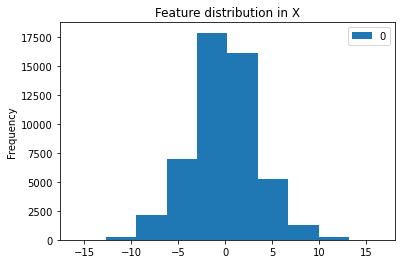

In [10]:
pandas.DataFrame(x_data_sample.flatten()).plot(kind='hist', title='Feature distribution in X')

<AxesSubplot:title={'center':'Feature distribution in Y'}, ylabel='Frequency'>

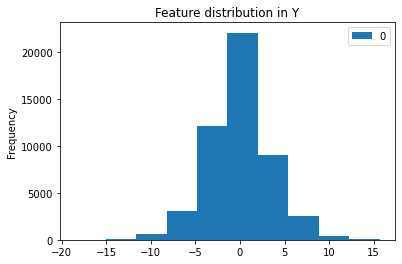

In [11]:
pandas.DataFrame(y_data_sample.flatten()).plot(kind='hist', title='Feature distribution in Y')

In [12]:
assert np.array_equal(x_data_sample, y_data_sample) is False, 'x and y are same. Should be different!'

Now, we confirmed that X and Y are very similar, but not same.

# Pre-experiment: X and Y is same when a sample = an observation?

We suppose that we have 500 time-series which has 350 features.

In [13]:
print(f"X(observation * time-length){x_data_sample.shape} Y(observation * time-length){y_data_sample.shape}")

X(observation * time-length)(500, 100) Y(observation * time-length)(500, 100)


<AxesSubplot:title={'center':'x in time-series sequence'}>

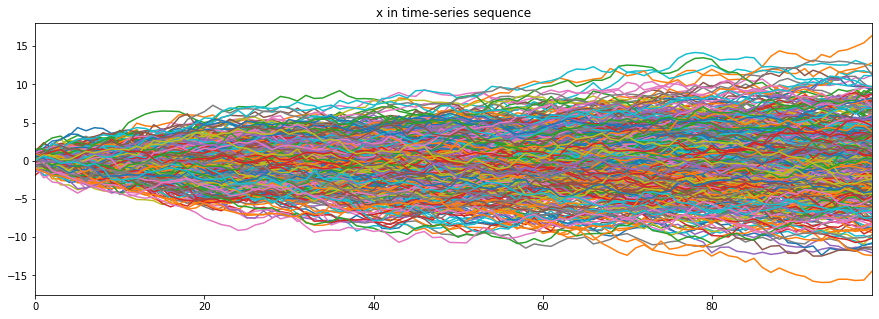

In [14]:
pandas.DataFrame(x_data_sample).transpose().plot(kind='line', legend=False, figsize=(15, 5), title='x in time-series sequence')

<AxesSubplot:title={'center':'y in time-series sequence'}>

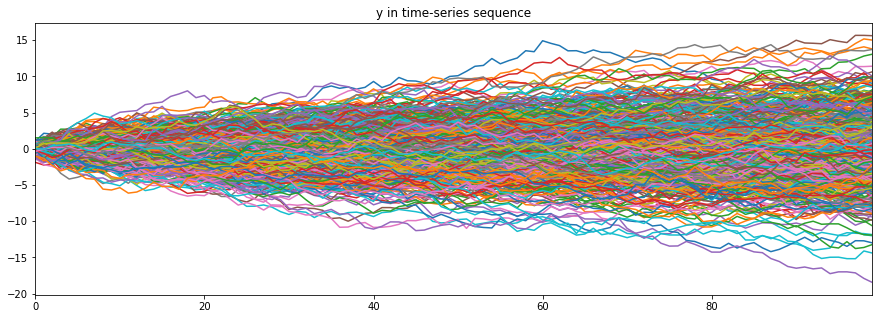

In [15]:
pandas.DataFrame(y_data_sample).transpose().plot(kind='line', legend=False, figsize=(15, 5), title='y in time-series sequence')

## Finding the best kernel for the test

We set RBF-Kernel and Matern-Kernel. As the same time, we optimize parameters of the kernels.

In [17]:
rbf_kernel = kernels_torch.BasicRBFKernelFunction(device_obj=device_obj, log_sigma=-1.0)
matern_0_5 = kernels_torch.MaternKernelFunction(nu=0.5, device_obj=device_obj, lengthscale=-1.0)
matern_1_5 = kernels_torch.MaternKernelFunction(nu=1.5, device_obj=device_obj, lengthscale=-1.0)
matern_2_5 = kernels_torch.MaternKernelFunction(nu=1.5, device_obj=device_obj, lengthscale=-1.0)

We set data for training, data for validation.

In [18]:
ratio_training = 0.8
ind_training = int(N_DATA_SIZE * ratio_training)
x_data_sample_train = x_data_sample[:ind_training, :]
x_data_sample_val = x_data_sample[ind_training:, :]
y_data_sample_train = y_data_sample[:ind_training, :]
y_data_sample_val = y_data_sample[ind_training:, :]

dataset_data_sample_train = TwoSampleDataSet(x_data_sample_train, y_data_sample_train, device_obj)
dataset_data_sample_val = TwoSampleDataSet(x_data_sample_val, y_data_sample_val, device_obj)

In [23]:
initial_scales = torch.tensor([0.5] * N_TIME_LENGHTH)
kernel_selector = SelectionKernels(num_epochs=250, 
                                   dataset_validation=dataset_data_sample_val, 
                                   device_obj=device_obj, 
                                   is_training=True, 
                                   dataset_training=dataset_data_sample_train, 
                                   candidate_kernels=[(initial_scales, rbf_kernel), 
                                                      (initial_scales, matern_0_5),
                                                      (initial_scales, matern_1_5),
                                                      (initial_scales, matern_2_5)])
selection_result = kernel_selector.run_selection()

2021-08-23 15:56:37,723 - model_criticism_mmd.logger_unit - INFO - Set the initial scales value
../model_criticism_mmd/backends/backend_torch.py:285: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor(init_scale.clone().detach().cpu(), requires_grad=True, device=self.device_obj)
2021-08-23 15:56:37,725 - model_criticism_mmd.logger_unit - INFO - Getting median initial sigma value...
2021-08-23 15:56:37,824 - model_criticism_mmd.logger_unit - INFO - initial by median-heuristics 3.46 with is_log=True
2021-08-23 15:56:37,860 - model_criticism_mmd.logger_unit - INFO - Validation at 0. MMD^2 = 0.009993436800867617, ratio = [2.0739316] obj = [-0.72944613]
2021-08-23 15:56:38,245 - model_criticism_mmd.logger_unit - INFO -      5: [avg train] MMD^2 0.0024120840258015086 obj [-2.05024787] val-MMD^2 0.010561740419731569 val-ratio 

In [24]:
import pprint
pprint.pprint(selection_result)

[Kernel-type: <model_criticism_mmd.backends.kernels_torch.matern_kernel.MaternKernelFunction object at 0x7f693e508c50>. Test-power: 3.2282265230056666,
 Kernel-type: <model_criticism_mmd.backends.kernels_torch.matern_kernel.MaternKernelFunction object at 0x7f693e508e80>. Test-power: 2.5099515610546552,
 Kernel-type: <model_criticism_mmd.backends.kernels_torch.matern_kernel.MaternKernelFunction object at 0x7f693e508e48>. Test-power: 2.5099515610546552,
 Kernel-type: <model_criticism_mmd.backends.kernels_torch.rbf_kernel.BasicRBFKernelFunction object at 0x7f693e508cf8>. Test-power: 2.3260468900025413]


## Permutation test with the best kernel

In [27]:
mmd_estimator_data_sample = MMD.from_trained_parameters(selection_result[0].trained_mmd_parameter, device_obj=device_obj)

In [28]:
dataset_for_permutation_test_data_sample = TwoSampleDataSet(x_data_sample, y_data_sample, device_obj)
test_operator_data_sample = PermutationTest(n_permutation_test=500,
                                            mmd_estimator=mmd_estimator_data_sample, 
                                            dataset=dataset_for_permutation_test_data_sample, 
                                            device_obj=device_obj)
mmd_data_sample = test_operator_data_sample.compute_statistic()
p_value_data_sample = test_operator_data_sample.compute_p_value(mmd_data_sample)

100%|██████████| 500/500 [00:09<00:00, 54.16it/s]


In [29]:
print(f"p-value: {p_value_data_sample}")

p-value: 0.596


p-value is > 0.05, therefore, X(data based) and Y(data based) are from same distributions.

# Main-experiment 1: permutation test when a sample = a time at t

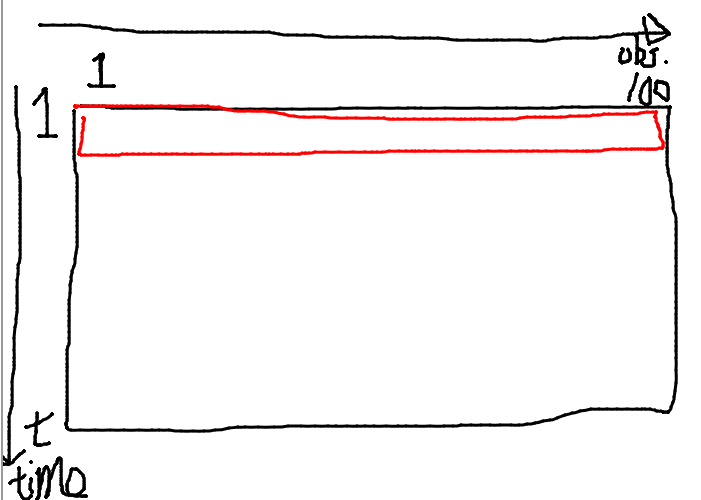

First, we transpose the matrix. With the transpose, one sample is one time-series.

In [23]:
x_time_sample = x_data_sample.transpose()
y_time_sample = y_data_sample.transpose()

In [24]:
print(f'shape of x (time-length * data): {x_time_sample.shape}, shape of y (time-length * data): {y_time_sample.shape}')

shape of x (time-length * data): (100, 500), shape of y (time-length * data): (100, 500)


Let's visualize the time-series of X and Y.

Now, we're gonna select the best kernel for the time-series based matrix form.

In [25]:
ratio_training = 0.8
ind_training = int(N_TIME_LENGHTH * ratio_training)
x_time_sample_train = x_time_sample[:ind_training, :]
x_time_sample_val = x_time_sample[ind_training:, :]
y_time_sample_train = y_time_sample[:ind_training, :]
y_time_sample_val = y_time_sample[ind_training:, :]

dataset_time_sample_train = TwoSampleDataSet(x_time_sample_train, y_time_sample_train, device_obj)
dataset_time_sample_val = TwoSampleDataSet(x_time_sample_val, y_time_sample_val, device_obj)

In [26]:
initial_scales = torch.tensor([0.5] * N_DATA_SIZE)
kernel_selector_time = SelectionKernels(num_epochs=250, 
                                   dataset_validation=dataset_time_sample_val, 
                                   device_obj=device_obj, 
                                   is_training=True, 
                                   dataset_training=dataset_time_sample_train, 
                                   candidate_kernels=[(initial_scales, rbf_kernel), 
                                                      (initial_scales, matern_0_5)])
selection_result_time = kernel_selector_time.run_selection()

2021-08-13 10:48:11,263 - model_criticism_mmd.logger_unit - INFO - Validation at 0. MMD^2 = 1.4715684850241173, ratio = [60.29533522] obj = [-4.09925474]
2021-08-13 10:48:11,623 - model_criticism_mmd.logger_unit - INFO -      5: [avg train] MMD^2 0.6245393141386644 obj [-2.99039788] val-MMD^2 1.4711669031363794 val-ratio [60.25206872] val-obj [-4.09853691]  elapsed: 0.0
2021-08-13 10:48:12,816 - model_criticism_mmd.logger_unit - INFO -     25: [avg train] MMD^2 0.6240784878036865 obj [-3.00601251] val-MMD^2 1.467381468341401 val-ratio [59.84429112] val-obj [-4.09174604]  elapsed: 0.0
2021-08-13 10:48:14,232 - model_criticism_mmd.logger_unit - INFO -     50: [avg train] MMD^2 0.6230686262785876 obj [-3.0304158] val-MMD^2 1.4615130548687558 val-ratio [59.21208278] val-obj [-4.08112562]  elapsed: 0.0
2021-08-13 10:48:17,027 - model_criticism_mmd.logger_unit - INFO -    100: [avg train] MMD^2 0.6199501413134052 obj [-3.07808618] val-MMD^2 1.4496584670532724 val-ratio [57.93975878] val-obj 

In [27]:
selection_result_time

[Kernel-type: <model_criticism_mmd.backends.kernels_torch.matern_kernel.MaternKernelFunction object at 0x7f59b9d64c18>. Test-power: 1000.1844449722629,
 Kernel-type: <model_criticism_mmd.backends.kernels_torch.rbf_kernel.BasicRBFKernelFunction object at 0x7f59b9d64ef0>. Test-power: 54.44002871714847]

In [28]:
mmd_estimator_time_sample = MMD.from_trained_parameters(selection_result_time[0].trained_mmd_parameter, device_obj)

In [29]:
dataset_for_permutation_test_time_sample = TwoSampleDataSet(x_time_sample, y_time_sample, device_obj)
test_operator_time_sample = PermutationTest(n_permutation_test=500,
                                            mmd_estimator=mmd_estimator_time_sample, 
                                            dataset=dataset_for_permutation_test_time_sample, 
                                            device_obj=device_obj)
mmd_time_sample = test_operator_time_sample.compute_statistic()
p_value_time_sample = test_operator_time_sample.compute_p_value(mmd_time_sample)

100%|██████████| 500/500 [00:03<00:00, 149.67it/s]


In [30]:
p_value_time_sample

0.46599999999999997

the p-value is > 0.05, therefore, we say that X(time based) and Y(time based) are from same distributions.

# pre-experiment 2: Normal distribution v.s. Laplase

We observe how permutation test works when X-noise is from Normal distribution and Y-noise is from Laplase distribution.

In [31]:
y_data_sample_laplace = np.zeros((N_DATA_SIZE, N_TIME_LENGHTH))
y_data_sample_laplace[:, 0] = INITIAL_VALUE_AT_ONE
for time_t in tqdm.tqdm(range(0, N_TIME_LENGHTH - 1)):
    noise_y = np.random.laplace(NOISE_MU_Y, NOISE_SIGMA_Y + 5, (N_DATA_SIZE,))
    y_data_sample_laplace[:, time_t + 1] = y_data_sample_laplace[:, time_t].flatten() + noise_y
    # end if
assert y_data_sample_laplace.shape == (N_DATA_SIZE, N_TIME_LENGHTH)
y_time_sample_laplace = y_data_sample_laplace.transpose()

100%|██████████| 99/99 [00:00<00:00, 15211.23it/s]


<AxesSubplot:title={'center':'x in time-series sequence'}>

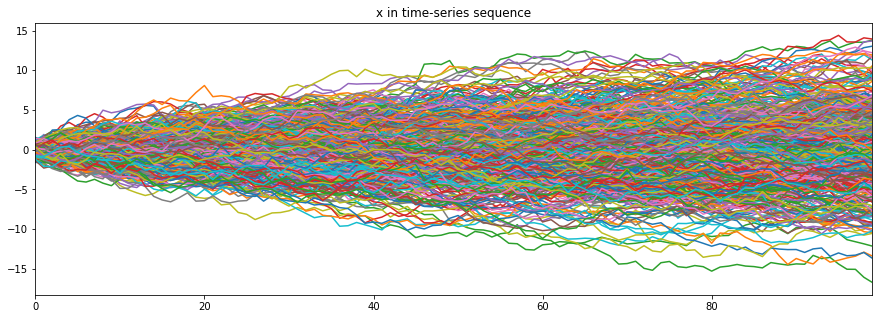

In [32]:
pandas.DataFrame(x_data_sample).transpose().plot(kind='line', legend=False, figsize=(15, 5), title='x in time-series sequence')

<AxesSubplot:title={'center':'y-laplase in time-series sequence'}>

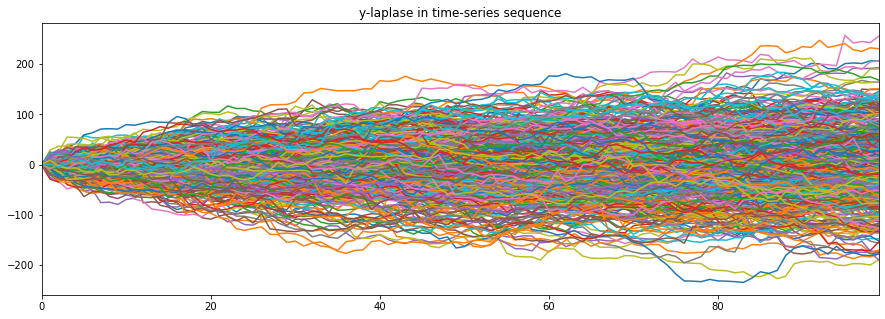

In [33]:
pandas.DataFrame(y_data_sample_laplace).transpose().plot(kind='line', legend=False, figsize=(15, 5), title='y-laplase in time-series sequence')

In [34]:
ratio_training = 0.8
ind_training = int(N_DATA_SIZE * ratio_training)
x_data_sample_train = x_data_sample[:ind_training, :]
x_data_sample_val = x_data_sample[ind_training:, :]
y_data_sample_laplace_train = y_data_sample_laplace[:ind_training, :]
y_data_sample_laplace_val = y_data_sample_laplace[ind_training:, :]

dataset_data_sample_train = TwoSampleDataSet(x_data_sample_train, y_data_sample_laplace_train, device_obj)
dataset_data_sample_val = TwoSampleDataSet(x_data_sample_val, y_data_sample_laplace_val, device_obj)

In [35]:
initial_scales = torch.tensor([0.5] * N_TIME_LENGHTH)
kernel_selector = SelectionKernels(num_epochs=250, 
                                   dataset_validation=dataset_data_sample_val, 
                                   device_obj=device_obj, 
                                   is_training=True, 
                                   dataset_training=dataset_data_sample_train, 
                                   candidate_kernels=[(initial_scales, rbf_kernel), 
                                                      (initial_scales, matern_0_5)])
selection_result = kernel_selector.run_selection()

2021-08-13 10:49:05,811 - model_criticism_mmd.logger_unit - INFO - Validation at 0. MMD^2 = 0.55301547535209, ratio = [22.70649765] obj = [-3.12265112]
2021-08-13 10:49:06,251 - model_criticism_mmd.logger_unit - INFO -      5: [avg train] MMD^2 0.5786106634336712 obj [-3.50796218] val-MMD^2 0.5637128599044724 val-ratio [23.22971594] val-obj [-3.14543232]  elapsed: 0.0
2021-08-13 10:49:07,967 - model_criticism_mmd.logger_unit - INFO -     25: [avg train] MMD^2 0.6779454261889046 obj [-3.76986524] val-MMD^2 0.670807967881793 val-ratio [30.43764866] val-obj [-3.41568029]  elapsed: 0.0
2021-08-13 10:49:09,959 - model_criticism_mmd.logger_unit - INFO -     50: [avg train] MMD^2 0.8612598558684385 obj [-4.6161706] val-MMD^2 0.8630985318159459 val-ratio [68.53724103] val-obj [-4.22737726]  elapsed: 0.0
2021-08-13 10:49:14,415 - model_criticism_mmd.logger_unit - INFO -    100: [avg train] MMD^2 0.8726328323371713 obj [-4.78440848] val-MMD^2 0.8745340785513722 val-ratio [78.85631971] val-obj [-

In [36]:
mmd_estimator_data_sample = MMD.from_trained_parameters(selection_result[0].trained_mmd_parameter, device_obj)

In [37]:
dataset_for_permutation_test_laplace = TwoSampleDataSet(x_data_sample, y_data_sample_laplace, device_obj)
test_operator_data_sample = PermutationTest(n_permutation_test=500,
                                            mmd_estimator=mmd_estimator_data_sample, 
                                            dataset=dataset_for_permutation_test_laplace, 
                                            device_obj=device_obj)
mmd_data_sample = test_operator_data_sample.compute_statistic()
p_value_data_sample = test_operator_data_sample.compute_p_value(mmd_data_sample)

100%|██████████| 500/500 [00:10<00:00, 48.26it/s]


In [38]:
print(p_value_data_sample)

0.0


We confirm that X and Y are different.

# Main-experiment 2: Normal distribution v.s. Laplase at one sample is time at t.

We observe how permutation test works when X-noise is from Normal distribution and Y-noise is from Laplase distribution.

In [39]:
print(x_time_sample.shape)

(100, 500)


<AxesSubplot:title={'center':'Feature distribution in X'}, ylabel='Frequency'>

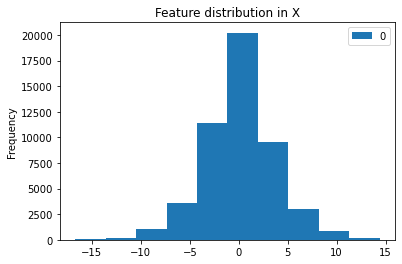

In [40]:
pandas.DataFrame(x_time_sample.flatten()).plot(kind='hist', title='Feature distribution in X')

In [41]:
print(y_time_sample_laplace.shape)

(100, 500)


<AxesSubplot:title={'center':'Feature distribution in Y-laplace'}, ylabel='Frequency'>

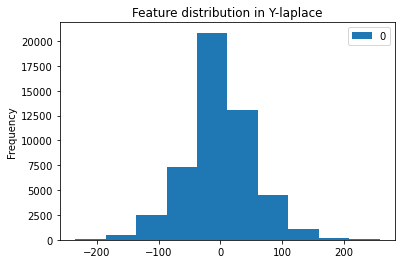

In [42]:
pandas.DataFrame(y_time_sample_laplace.flatten()).plot(kind='hist', title='Feature distribution in Y-laplace')

In [43]:
ratio_training = 0.8
ind_training = int(N_TIME_LENGHTH * ratio_training)
x_time_sample_train = x_time_sample[:ind_training, :]
x_time_sample_val = x_time_sample[ind_training:, :]
y_time_sample_laplace_train = y_time_sample_laplace[:ind_training, :]
y_time_sample_laplace_val = y_time_sample_laplace[ind_training:, :]

dataset_time_sample_train = TwoSampleDataSet(x_time_sample_train, y_time_sample_laplace_train, device_obj)
dataset_time_sample_val = TwoSampleDataSet(x_time_sample_val, y_time_sample_laplace_val, device_obj)

In [44]:
initial_scales = torch.tensor([0.5] * N_DATA_SIZE)
kernel_selector_time_laplace = SelectionKernels(num_epochs=250, 
                                   dataset_validation=dataset_time_sample_val, 
                                   device_obj=device_obj, 
                                   is_training=True, 
                                   dataset_training=dataset_time_sample_train, 
                                   candidate_kernels=[(initial_scales, rbf_kernel), 
                                                      (initial_scales, matern_0_5)])
selection_result_time_laplace = kernel_selector_time_laplace.run_selection()

2021-08-13 10:50:13,279 - model_criticism_mmd.logger_unit - INFO - Validation at 0. MMD^2 = 0.7873660812032088, ratio = [42.86443608] obj = [-3.75804249]
2021-08-13 10:50:13,707 - model_criticism_mmd.logger_unit - INFO -      5: [avg train] MMD^2 0.3865044846414634 obj [-3.44490142] val-MMD^2 0.7873815102412388 val-ratio [42.85886205] val-obj [-3.75791244]  elapsed: 0.0
2021-08-13 10:50:15,149 - model_criticism_mmd.logger_unit - INFO -     25: [avg train] MMD^2 0.38591300864547895 obj [-3.46365309] val-MMD^2 0.7874520731918006 val-ratio [42.79257751] val-obj [-3.75636466]  elapsed: 0.0
2021-08-13 10:50:16,750 - model_criticism_mmd.logger_unit - INFO -     50: [avg train] MMD^2 0.3845249326323863 obj [-3.4939732] val-MMD^2 0.7872572456932087 val-ratio [42.63270909] val-obj [-3.75262178]  elapsed: 0.0
2021-08-13 10:50:19,867 - model_criticism_mmd.logger_unit - INFO -    100: [avg train] MMD^2 0.3795776951074352 obj [-3.55876701] val-MMD^2 0.7854724919780772 val-ratio [42.04803343] val-ob

In [45]:
selection_result_time_laplace

[Kernel-type: <model_criticism_mmd.backends.kernels_torch.matern_kernel.MaternKernelFunction object at 0x7f59b9d64c18>. Test-power: 1000.0676446110334,
 Kernel-type: <model_criticism_mmd.backends.kernels_torch.rbf_kernel.BasicRBFKernelFunction object at 0x7f59b9d64ef0>. Test-power: 37.70207267032868]

In [46]:
mmd_estimator_time_sample = MMD.from_trained_parameters(selection_result_time_laplace[0].trained_mmd_parameter, device_obj)

In [47]:
dataset_for_permutation_test_time_laplace_sample = TwoSampleDataSet(x_time_sample, y_time_sample_laplace, device_obj)
test_operator_time_sample = PermutationTest(n_permutation_test=1000,
                                            mmd_estimator=mmd_estimator_time_sample, 
                                            dataset=dataset_for_permutation_test_time_laplace_sample, 
                                            device_obj=device_obj)
mmd_time_sample = test_operator_time_sample.compute_statistic()
p_value_time_sample = test_operator_time_sample.compute_p_value(mmd_time_sample)

100%|██████████| 1000/1000 [00:08<00:00, 117.16it/s]


In [48]:
print(f"p-value {p_value_time_sample}")

p-value 0.49


Now, we see a case of a contradiction. The distribution is different apparently, however, Permutation test says "the same distribution." The case is $Type2\ Error$.

I investigate why the error raises.

In [49]:
print(f"MMD at whole data {mmd_time_sample}")

MMD at whole data 0.019802115401321846


<AxesSubplot:title={'center':'mmd frequency during permutation test (upper)'}, ylabel='Frequency'>

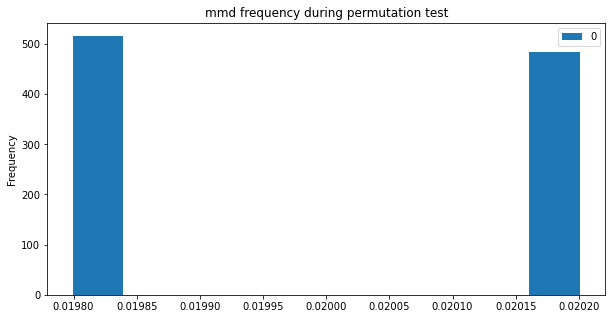

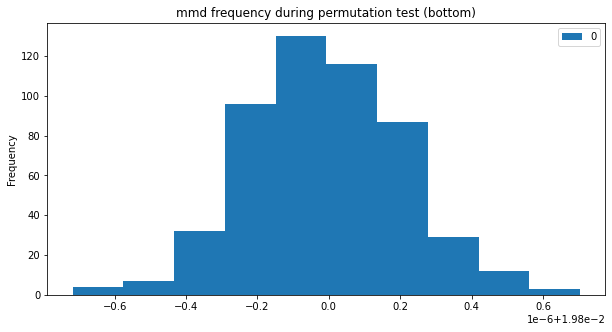

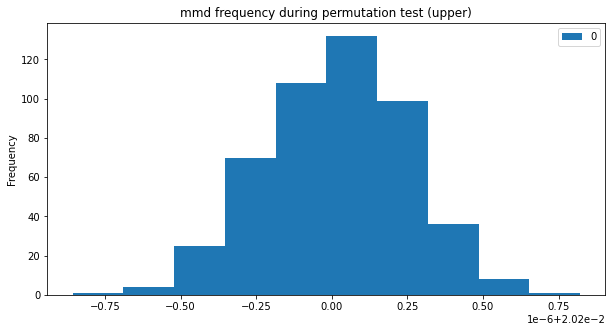

In [50]:
pandas.DataFrame(test_operator_time_sample.stats_permutation_test).plot(kind='hist', title='mmd frequency during permutation test', figsize=(10, 5))
pandas.DataFrame(test_operator_time_sample.stats_permutation_test[test_operator_time_sample.stats_permutation_test < 0.01990]).plot(kind='hist', title='mmd frequency during permutation test (bottom)', figsize=(10, 5))
pandas.DataFrame(test_operator_time_sample.stats_permutation_test[test_operator_time_sample.stats_permutation_test > 0.02010]).plot(kind='hist', title='mmd frequency during permutation test (upper)', figsize=(10, 5))

## Solution to the error

### Solution-1: elaborated sampling during permutation

I ask myself why permutation result will be biased. 
As an assumption, time-index gives huge influence on statistic on permutations.

MMD value goes small __if permutation tends to select similar time-t between X and Y__.
MMD value goes big __if permutation tends to select time-t in small index and big index__.

If the assumption is truth, we can improve the permutation by sampling strategy.

Now, I try to implement well-controlled sampling.

The sampling selects good balance of samples from small-var-area and big-var-area.

In [49]:
num_permutations = 1000
import random
from datetime import datetime

all_samples = test_operator_time_sample.dataset.get_all_item()
x_all = all_samples[0]
y_all = all_samples[1]
z = torch.cat([x_all, y_all], 0)  # SOLUTION
n_x = x_all.shape[0]
n_y = y_all.shape[0]
stats = []

range_ = range(num_permutations)
range_ = tqdm.tqdm(range_)

selected_index = []

z_a_small = z[0:40, :]
z_a_big = z[41:, :]

z_b_small = z[100:140, :]
z_b_big = z[141:, :]

z_small = torch.cat([z_a_small, z_b_small])
z_big = torch.cat([z_a_big, z_b_big])

n_sample_small = int(z_small.shape[0] / 2)
n_sample_big = int(z_big.shape[0] / 2)

print(n_sample_small, n_sample_big)

for i in range_:    
    # Well-balanced sampling. time-t until 40(small variance) / time-t in 40-100(big-variance)
    
    z_small_shuffle = z_small[torch.randperm(z_small.size()[0])]
    z_big_shuffle = z_big[torch.randperm(z_big.size()[0])]
    
    z_a = torch.cat([z_small_shuffle[:n_sample_small], z_big_shuffle[:n_sample_big]])
    z_b = torch.cat([z_small_shuffle[n_sample_small:], z_big_shuffle[n_sample_big:]])
    
    assert z_a.shape[0] == z_b.shape[0]
    mmd_values = mmd_estimator_time_sample.mmd_distance(z_a, z_b)
    stats.append(mmd_values.mmd.detach().cpu().numpy())
# end for
frequency_array = np.array(stats)

  1%|          | 9/1000 [00:00<00:11, 89.60it/s]

40 109


100%|██████████| 1000/1000 [00:08<00:00, 114.54it/s]


<AxesSubplot:title={'center':'mmd frequency during permutation test'}, ylabel='Frequency'>

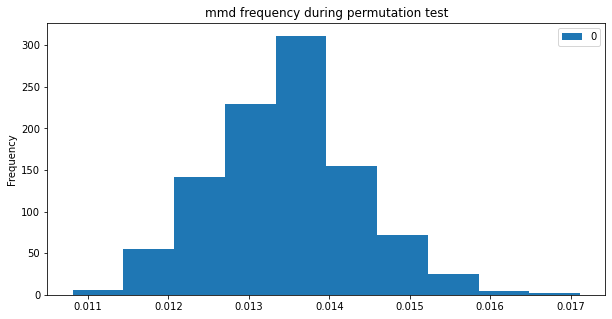

In [50]:
pandas.DataFrame(frequency_array).plot(kind='hist',
                                       title='mmd frequency during permutation test', figsize=(10, 5))

In [51]:
print(f'MMD(whole) is {mmd_time_sample}. Judging from the distribution above, the max-value is around 0.016. Thus, p-value is 0.0')

MMD(whole) is 0.019801412852514334. Judging from the distribution above, the max-value is around 0.016. Thus, p-value is 0.0


## Solution-2: RBF Kernel

If you look at the result of kernel-selection.

The ratio with Matérn Kernel is with too huge value, on the other hand, RBF Kernel is with low ratio value.

The big difference may suggest over-fitting of parameters. Now, it's a natural idea to run permutation tests with RBF Kernel.

In [53]:
rbf_mmd_estimator_time_sample = MMD.from_trained_parameters(selection_result_time_laplace[1].trained_mmd_parameter, device_obj)

In [54]:
dataset_for_permutation_test_time_laplace_sample = TwoSampleDataSet(x_time_sample, y_time_sample_laplace, device_obj)
test_operator_time_sample = PermutationTest(n_permutation_test=1000,
                                            mmd_estimator=rbf_mmd_estimator_time_sample, 
                                            dataset=dataset_for_permutation_test_time_laplace_sample, 
                                            device_obj=device_obj)
mmd_time_sample = test_operator_time_sample.compute_statistic()
p_value_time_sample = test_operator_time_sample.compute_p_value(mmd_time_sample)

100%|██████████| 1000/1000 [00:01<00:00, 543.80it/s]


In [57]:
print(f'p-value with RBF kernel: {p_value_time_sample}')
print(f'MMD value with the whole dataset: {mmd_time_sample}')

p-value with RBF kernel: 0.0
MMD value with the whole dataset: 0.2960153006234904


<AxesSubplot:title={'center':'mmd frequency during permutation test(RBF)'}, ylabel='Frequency'>

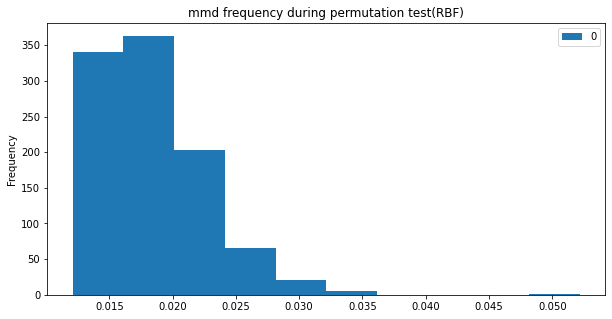

In [56]:
pandas.DataFrame(test_operator_time_sample.stats_permutation_test).plot(kind='hist',
                                                                        title='mmd frequency during permutation test(RBF)', figsize=(10, 5))

### depper analysis into type 2 error.

This section shows you investigations in detail, why the type 2 error raises.

We check reasons behind the unnatural frequency histogram.

In [58]:
num_permutations = 1000
import random
from datetime import datetime

all_samples = test_operator_time_sample.dataset.get_all_item()
x_all = all_samples[0]
y_all = all_samples[1]
z = torch.cat([x_all, y_all], 0)  # SOLUTION
n_x = x_all.shape[0]
n_y = y_all.shape[0]
stats = []

range_ = range(num_permutations)
range_ = tqdm.tqdm(range_)

selected_index = []

for i in range_:
    # original
    z_a_ind = random.Random(datetime.now().microsecond).sample(range(0, len(z)), n_x)
    z_a_ind = random.Random().sample(range(0, len(z)), n_x)
    z_b_ind = list(set(range(0, len(z))) - set(z_a_ind))
    # save selected index
    selected_index.append([z_a_ind, z_b_ind])
    
    z_a = z[z_a_ind, :]
    z_b = z[z_b_ind, :]
    # original until here.
    mmd_values = mmd_estimator_time_sample.mmd_distance(z_a, z_b)
    stats.append(mmd_values.mmd.detach().cpu().numpy())
# end for
frequency_array = np.array(stats)

100%|██████████| 1000/1000 [00:05<00:00, 166.70it/s]


In [59]:
num_permutations = 1000
import random
from datetime import datetime

mmd_estimator_time_sample = MMD.from_trained_parameters(selection_result_time_laplace[1].trained_mmd_parameter, 
                                                        device_obj)

all_samples = test_operator_time_sample.dataset.get_all_item()
x_all = all_samples[0]
y_all = all_samples[1]
z = torch.cat([x_all, y_all], 0)  # SOLUTION
n_x = x_all.shape[0]
n_y = y_all.shape[0]
stats = []

range_ = range(num_permutations)
range_ = tqdm.tqdm(range_)

prev_z_0_record = z[0, :]
for i in range_:
    z_shuffle = z[torch.randperm(z.size()[0])]
    # assert torch.all(torch.eq(z_shuffle[0, :], prev_z_0_record) == False)
    prev_z_0_record = z_shuffle[0, :]
    z_a = z_shuffle[z_a_ind, :]
    z_b = z_shuffle[z_b_ind, :]
    # original until here.
    mmd_values = mmd_estimator_time_sample.mmd_distance(z_a, z_b)
    stats.append(mmd_values.mmd.detach().cpu().numpy())
# end for
frequency_array = np.array(stats)

100%|██████████| 1000/1000 [00:01<00:00, 527.86it/s]


In [61]:
selected_ind_upper = [selected_index[i] for i in permutation_number_upper[0]]
selected_ind_upper_z_a = np.array([g[0] for g in selected_ind_upper])
selected_ind_upper_z_b = np.array([g[1] for g in selected_ind_upper])

In [62]:
upper_values_mean = []
for z_a, z_b in zip(selected_ind_upper_z_a, selected_ind_upper_z_b):
    z_a_mean = torch.mean(z[z_a])
    z_a_var = torch.var(z[z_a])
    
    z_b_mean = torch.mean(z[z_b])
    z_b_var = torch.var(z[z_b])
    upper_values_mean.append({
        'mean_z_a': float(z_a_mean.detach().cpu().numpy()), 
        'mean_z_b': float(z_b_mean.detach().cpu().numpy()),
        'var_z_a': float(z_a_var.detach().cpu().numpy()),
        'var_z_b': float(z_b_var.detach().cpu().numpy())}) 
# end for
df_upper_values_mean = pandas.DataFrame(upper_values_mean)

In [63]:
selected_ind_bottom = [selected_index[i] for i in permutation_number_bottom[0]]
selected_ind_bottom_z_a = np.array([g[0] for g in selected_ind_bottom])
selected_ind_bottom_z_b = np.array([g[1] for g in selected_ind_bottom])

In [64]:
bottom_values_mean = []
bottom_values_var = []
for z_a, z_b in zip(selected_ind_bottom_z_a, selected_ind_bottom_z_b):
    z_a_mean = torch.mean(z[z_a])
    z_a_var = torch.var(z[z_a])
    
    z_b_mean = torch.mean(z[z_b])
    z_b_var = torch.var(z[z_b])
    bottom_values_mean.append({'mean_z_a': float(z_a_mean.detach().cpu().numpy()), 
                               'mean_z_b': float(z_b_mean.detach().cpu().numpy()),
                               'var_z_a': float(z_a_var.detach().cpu().numpy()),
                               'var_z_b': float(z_b_var.detach().cpu().numpy())})
# end for
df_bottom_values_mean = pandas.DataFrame(bottom_values_mean)

<AxesSubplot:title={'center':'Mean of Permutatios in bottom part'}, xlabel='mean_z_a', ylabel='mean_z_b'>

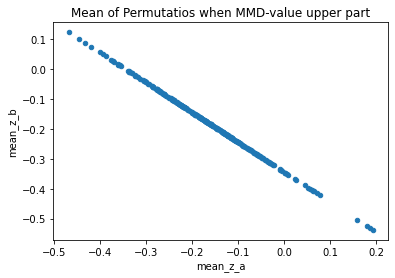

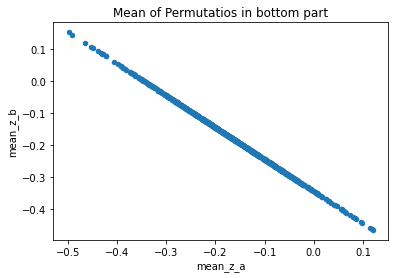

In [71]:
xlim = (1.1, 2.5)
ylim = (1.1, 2.5)
df_upper_values_mean.plot(kind='scatter', x='mean_z_a', y='mean_z_b', title='Mean of Permutatios when MMD-value upper part')
df_bottom_values_mean.plot(kind='scatter', x='mean_z_a', y='mean_z_b', title='Mean of Permutatios in bottom part')

<AxesSubplot:title={'center':'Variance of Permutatios when MMD-value bottom part'}, xlabel='var_z_a', ylabel='var_z_b'>

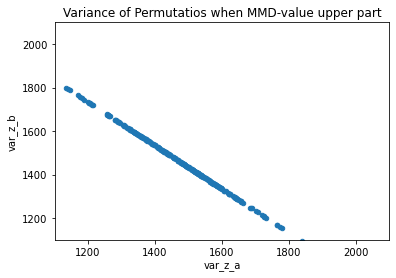

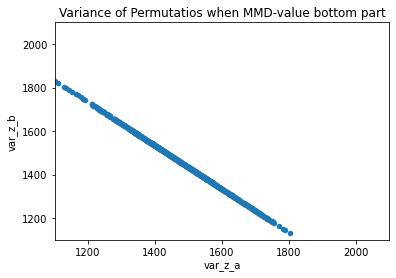

In [66]:
xlim = (1100, 2100)
ylim = (1100, 2100)
pandas.DataFrame(upper_values_mean).plot(kind='scatter', x='var_z_a', y='var_z_b', xlim=xlim, ylim=ylim, title='Variance of Permutatios when MMD-value upper part')
pandas.DataFrame(df_bottom_values_mean).plot(kind='scatter', x='var_z_a', y='var_z_b', xlim=xlim, ylim=ylim, title='Variance of Permutatios when MMD-value bottom part')

In [67]:
print(f'{len(permutation_number_upper[0])} times, MMD value more than 0.02')

289 times, MMD value more than 0.02


We pick up 10 permutations and visualize Z_a and Z_b
0.036541361445063314


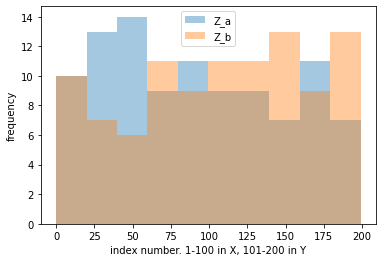

0.03555474431441058


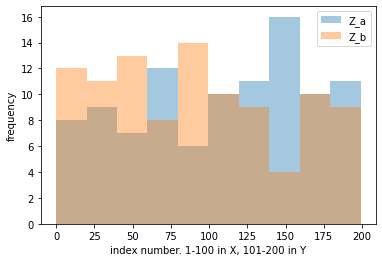

0.03421363972960126


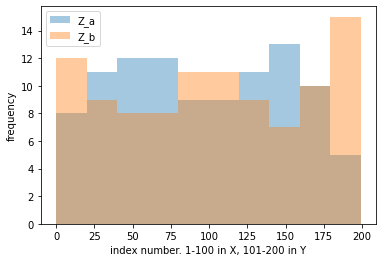

0.03410932717019449


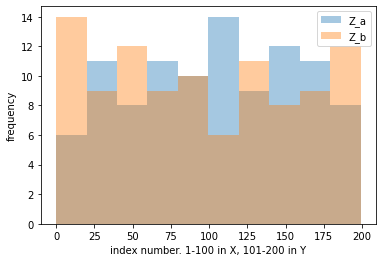

0.03335410420421778


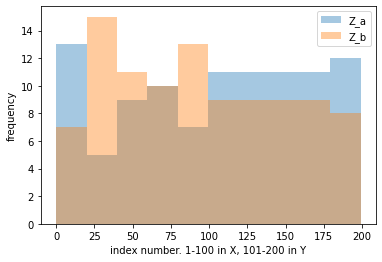

0.03237124980054065


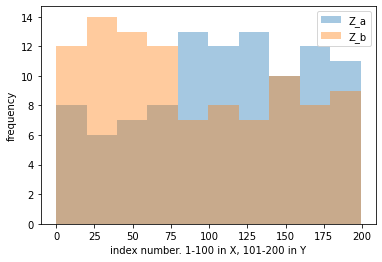

0.03227589836726494


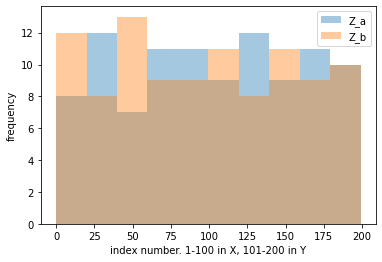

0.032184651164757855


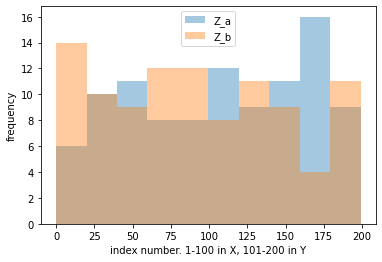

0.03195780030825385


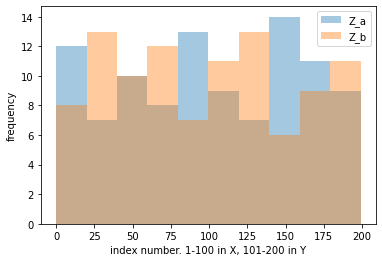

0.03193047821514844


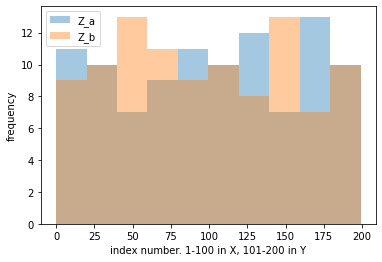

In [68]:
n_pick_up = 10
print(f'We pick up {n_pick_up} permutations and visualize Z_a and Z_b')
sort_index_upper = np.argsort(frequency_array[permutation_number_upper])[::-1]
for i_pick_up in range(0, n_pick_up):
    sort_index = sort_index_upper[i_pick_up]
    mmd_value = frequency_array[permutation_number_upper][sort_index]
    print(mmd_value)
    pandas.DataFrame({'Z_a': selected_ind_upper_z_a[sort_index], 
                      'Z_b': selected_ind_upper_z_b[sort_index]}).plot.hist(alpha=0.4)
    plt.ylabel("frequency")
    plt.xlabel("index number. 1-100 in X, 101-200 in Y")
    plt.show()

We pick up 10 permutations and visualize Z_a and Z_b
0.012024221352036651


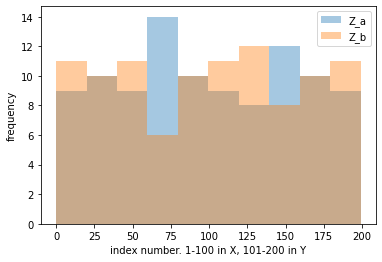

0.012035842926075235


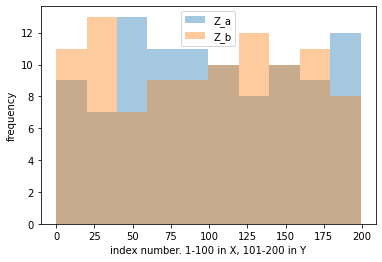

0.012049680074731478


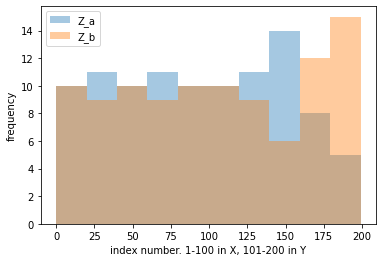

0.012230320252681837


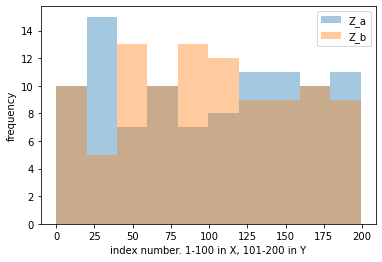

0.012310029949570617


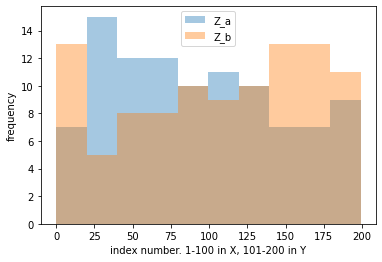

0.01238265152468801


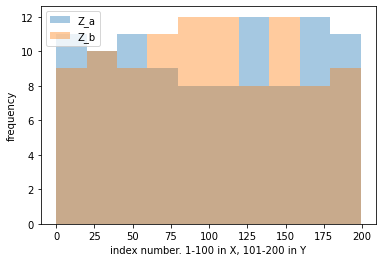

0.012422117512288694


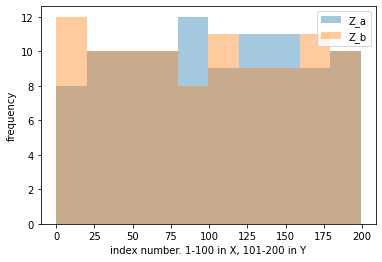

0.012455893913369404


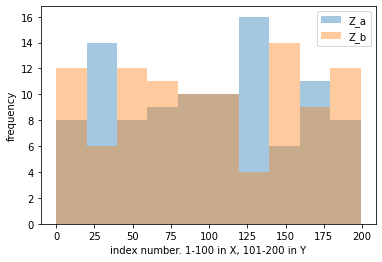

0.012459404128858764


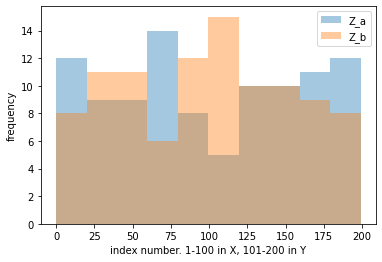

0.012550713535253888


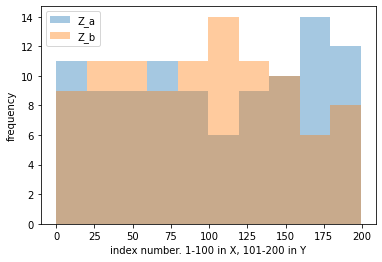

In [69]:
n_pick_up = 10
print(f'We pick up {n_pick_up} permutations and visualize Z_a and Z_b')
sort_index_bottom = np.argsort(frequency_array[permutation_number_bottom])
for i_pick_up in range(0, n_pick_up):
    index_sort = sort_index_bottom[i_pick_up]
    mmd_value = frequency_array[permutation_number_bottom][index_sort]
    print(mmd_value)
    pandas.DataFrame({'Z_a': selected_ind_bottom_z_a[index_sort], 
                      'Z_b': selected_ind_bottom_z_b[index_sort]}).plot.hist(alpha=0.4)
    plt.ylabel("frequency")
    plt.xlabel("index number. 1-100 in X, 101-200 in Y")
    plt.show()

# Conclusion

We found a case of Type 2 Error when we conduct tests with a condition of a sample = time at t.

For the solution, we have 2 alternative approaches.

1. using another samplig strategy.
2. using not Matérn kernel but RBF kernel.